In [58]:
graph_folder:str = '../data/pggb_vs_mgc'
edition_file: str = '../temp/yeast_edit'
matrix:str = '../temp/matrix.json'
mash_matrix:str = '../temp/mash.json'

In [59]:
# Colorblind-friendly palette
colors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

In [60]:
from seaborn import heatmap, boxplot,stripplot, clustermap, scatterplot, regplot, color_palette
from numpy import triu,array,add,zeros,column_stack, nan
from matplotlib import pyplot as plt
from os import listdir, path
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib import patches as mpatches
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from subprocess import run, PIPE
from scipy.spatial.distance import euclidean
from statistics import mean,median
from pandas import DataFrame,wide_to_long
from pgGraphs import Graph
from math import floor
from os import system, remove, path
from json import load, dump
from tharospytools.matplotlib_tools import get_palette_from_list

Manipulating graph names

In [61]:
all_graphs: list = sorted(listdir(graph_folder))
all_graphs.insert(0, all_graphs.pop())
print(all_graphs)

['15_yeast_pggb_chr_1.gfa', '15_yeast_mgc_CASBIT01_chr_1.gfa', '15_yeast_mgc_CASBIW01_chr_1.gfa', '15_yeast_mgc_CASBIZ01_chr_1.gfa', '15_yeast_mgc_CASBJG01_chr_1.gfa', '15_yeast_mgc_CASBJH01_chr_1.gfa', '15_yeast_mgc_CASBJI01_chr_1.gfa', '15_yeast_mgc_CASBJJ01_chr_1.gfa', '15_yeast_mgc_CASBJL01_chr_1.gfa', '15_yeast_mgc_CASBJM01_chr_1.gfa', '15_yeast_mgc_CASBJN01_chr_1.gfa', '15_yeast_mgc_CASBJQ01_chr_1.gfa', '15_yeast_mgc_CASBJS01_chr_1.gfa', '15_yeast_mgc_CASBJT01_chr_1.gfa', '15_yeast_mgc_CASBJU01_chr_1.gfa', '15_yeast_mgc_CASBJV01_chr_1.gfa']


In [62]:
node_matrix:str = '../temp/dnodes.json'

if path.exists(node_matrix):
    nodes:list[list[int]] = load(open(node_matrix))
else:
    nodes:list[list[float]] = [
            [
            0 for _ in range(len(all_graphs))
        ] for _ in range(len(all_graphs))
    ]
    nodes_counts:list[int] = [len(Graph(path.join(graph_folder,graph)).segments) for graph in all_graphs]
    
    for i in range(len(all_graphs)):
        for j in range(len(all_graphs)):
            nodes[i][j] = nodes_counts[i]
            nodes[j][i] = nodes_counts[j]
        
    dump(nodes, open(node_matrix, 'w'))

In [63]:
gfa_graph:Graph = Graph(
    gfa_file=f'{graph_folder}/{all_graphs[0]}'
)

Computing pairwise mash distance

In [64]:
graph_paths:list[str] = sorted(list(gfa_graph.paths.keys()))

In [65]:
if path.exists(mash_matrix):
    mash: list[list[int]] = load(open(mash_matrix,'r',encoding='utf-8'))
else:
    mash:list[list[float]] = [
            [
            0 for _ in range(len(graph_paths))
        ] for _ in range(len(graph_paths))
    ]

    for i,path_name_A in enumerate(graph_paths):
        for j,path_name_B in enumerate(graph_paths):
            mash[i][j]=float(run(['mash', 'dist',f'temp/{path_name_A}.fa',f'temp/{path_name_B}.fa'], stdout=PIPE).stdout.decode('utf-8').split()[2])
    dump(mash,open(mash_matrix,'w',encoding='utf-8'))

In [66]:
for row in mash:
    print("\t".join([str(elt) for elt in row]))

0.0	0.0134036	0.0107836	0.00483188	0.015508	0.0097316	0.0102298	0.00892796	0.0146626	0.00888862	0.00567497	0.0152404	0.0108702	0.00705245	0.00587519
0.0134036	0.0	0.0143537	0.0125875	0.00594242	0.0141502	0.0133059	0.0115761	0.0184352	0.0125405	0.0168391	0.00726808	0.0143537	0.0136991	0.0170111
0.0107836	0.0143537	0.0	0.010441	0.0149234	0.0127767	0.0152404	0.0129677	0.0162193	0.0114865	0.0124	0.0134036	0.00744966	0.0130638	0.0127767
0.00483188	0.0125875	0.010441	0.0	0.0144562	0.0106545	0.0110882	0.00694555	0.015347	0.00652391	0.00617965	0.0143027	0.0103986	0.00748619	0.00766986
0.015508	0.00594242	0.0149234	0.0144562	0.0	0.014871	0.0133059	0.0132087	0.0182524	0.0130157	0.0184352	0.00417861	0.0145076	0.0154542	0.0186813
0.0097316	0.0141502	0.0127767	0.0106545	0.014871	0.0	0.0120298	0.0126347	0.0160531	0.0129677	0.0100207	0.0136496	0.0144049	0.0106545	0.0100623
0.0102298	0.0133059	0.0152404	0.0110882	0.0133059	0.0120298	0.0	0.0112201	0.0146108	0.0120298	0.00846101	0.0144049	0.0149759	0.00

Computing mean and median of mash distance to every other for each sequence

In [67]:
mean_mash:dict = {
    path_name:mean(mash[i]) for i,path_name in enumerate(graph_paths)
}

median_mash:dict = {
    path_name:median(mash[i]) for i,path_name in enumerate(graph_paths)
}

sum_mash:dict = {
    path_name:sum(mash[i]) for i,path_name in enumerate(graph_paths)
}

Computing distances

In [68]:
# First, we compute edition to be sure to have a list of breakpoints
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

if path.exists(matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
else:
    for i,graph_A in enumerate(all_graphs):
        for j,graph_B in enumerate(all_graphs):
            if i < j:
                # Compute edition
                system(f'pancat edit data/{graph_A} data/{graph_B} -o {edition_file}_{i}_{j}.json')
                # Load edit file in memory
                editions:dict[str,list] = load(open(f"{edition_file}_{i}_{j}.json",'r',encoding='utf-8'))
                # Count editions
                edit_count:int = sum([sum([len(edit_list) for edit_list in edition_classes.values()]) for edition_classes in editions.values()])
                # add count to the two positions
                distance_martix[i][j] = edit_count
                distance_martix[j][i] = edit_count
                # delete temp file
                #remove(edition_file)
                
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))

In [69]:
for i,row in enumerate(distance_martix):
    print("\t".join([str(elt) for elt in row])+'\t|\t'+str(sum([elt for elt in row if elt != 0])/(len(row)-1))+'\t|\t'+str(all_graphs[i]))
    

0	86475	93432	98735	87932	88006	94277	71602	81715	79158	93530	82455	99186	94491	84409	80148	|	87703.4	|	15_yeast_pggb_chr_1.gfa
86475	0	86245	95466	83017	87559	62010	84791	69912	70809	72317	56196	90341	85764	56372	61157	|	76562.06666666667	|	15_yeast_mgc_CASBIT01_chr_1.gfa
93432	86245	0	96263	60690	60686	95089	84096	50705	70568	64464	90255	86404	95149	83577	71966	|	79305.93333333333	|	15_yeast_mgc_CASBIW01_chr_1.gfa
98735	95466	96263	0	80927	92715	100696	96325	86190	94625	85413	86442	72289	72124	83808	96607	|	89241.66666666667	|	15_yeast_mgc_CASBIZ01_chr_1.gfa
87932	83017	60690	80927	0	59140	97497	76078	40973	67572	53688	85547	80722	85837	80121	64636	|	73625.13333333333	|	15_yeast_mgc_CASBJG01_chr_1.gfa
88006	87559	60686	92715	59140	0	95053	76476	57937	64056	66350	88019	76646	94033	84043	63526	|	76949.66666666667	|	15_yeast_mgc_CASBJH01_chr_1.gfa
94277	62010	95089	100696	97497	95053	0	74481	84904	79557	88337	70768	105427	100520	68786	77593	|	86333.0	|	15_yeast_mgc_CASBJI01_chr_1.gfa
71

In [70]:
# Getting the mean value of edits for MC graphs:
index_pggb = str(all_graphs.index('15_yeast_pggb_chr_1.gfa'))
sum_values_mc = 0
count_values_mc = 0
sum_values_pggb = 0
count_values_pggb = 0
for i,row in enumerate(distance_martix):
    for j,elt in enumerate(row):
        if i != index_pggb and j != index_pggb and elt != 0:
            sum_values_mc += elt
            count_values_mc += 1
        if j == index_pggb and elt != 0:
            sum_values_pggb += elt
            count_values_pggb += 1
            
print("MC graphs: " + str(sum_values_mc/count_values_mc))

MC graphs: 78065.25833333333


82221.9375
[71776.9375, 74349.3125, 83664.0625, 69023.5625, 72140.3125, 80937.1875, 75882.8125, 61870.9375, 66729.6875, 66264.6875, 70849.6875, 80126.6875, 80647.3125, 68869.3125, 65624.4375]


/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


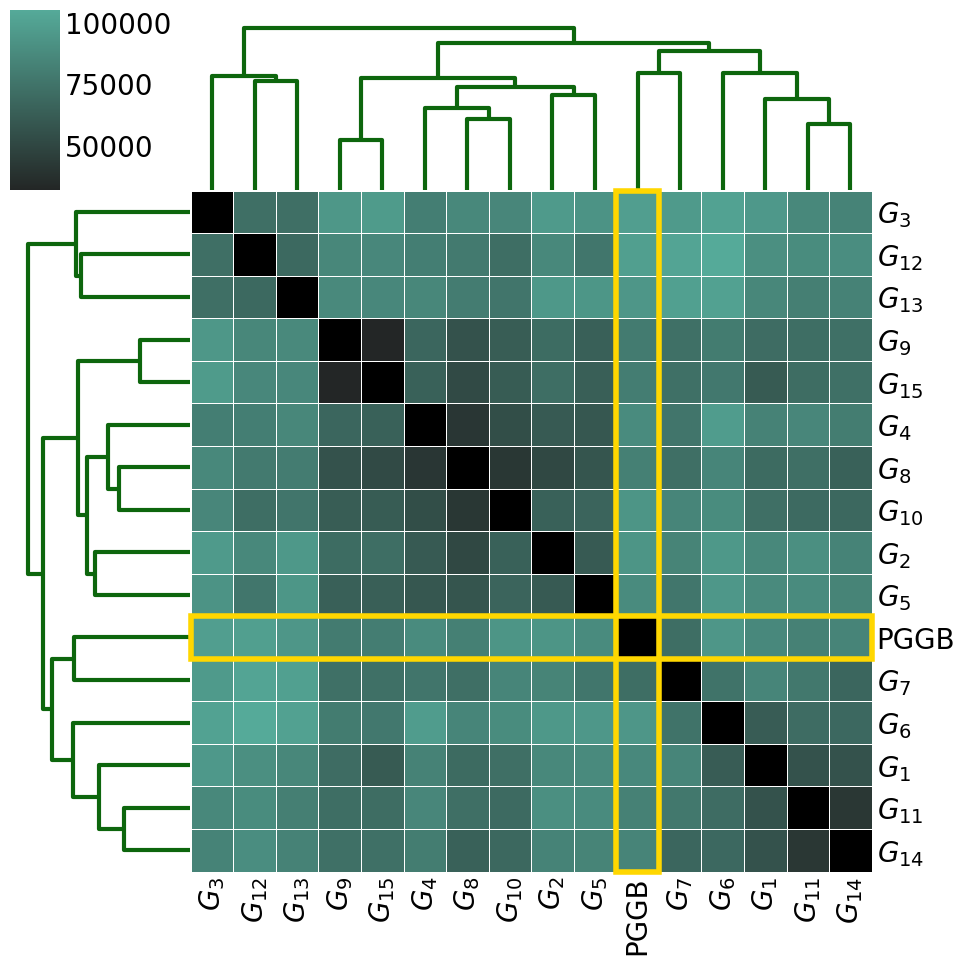

In [71]:
# Setting font parameters
plt.rcParams.update({'font.size': 20})


print(mean(distance_martix[0]))
print([mean(x) for x in distance_martix[1:]])

# We define labels list
labels:list[str] = ['PGGB' if 'pggb' in label else '$G_{'+str(idx)+'}$' for idx,label in enumerate(all_graphs)]
# Defining colors
green_pal = color_palette("dark:#5A9", as_cmap=True)
green_pal.set_bad("black")
colors = ['white'] + get_palette_from_list([sum_mash[x] for x in graph_paths],cmap_name='Greens')
# Transforming into pandas
df:DataFrame = DataFrame(distance_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.4, 0.05)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    #col_colors=colors,
    #row_colors=colors,
)
#xticklabels=['PGGB']+[round(mean_mash[x],3) for x in graph_paths],
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)

# We add a square to highlight a specific graph
reordered_labels:list[int] = df.index[fig.dendrogram_row.reordered_ind].tolist()
# PGGB is at location 0
pggb_pos:int = reordered_labels.index(0)
# We then add the patch to highlight the PGGB graph
x, y, w, h = 0, pggb_pos, len(reordered_labels), 1
for _ in range(2):
    fig.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='gold', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h

plt.savefig("F1B.eps")
plt.show()


Total: r=-0.09, p=1.30e-01


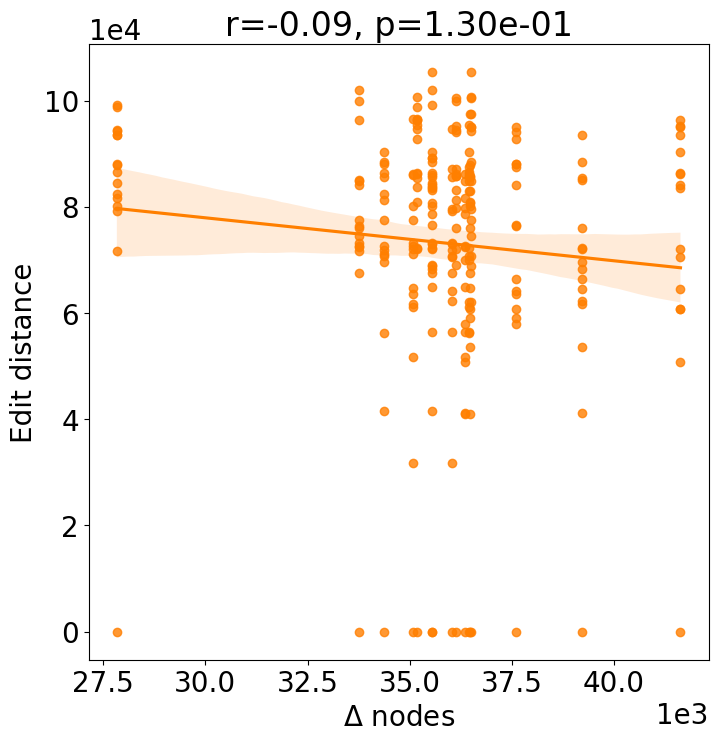

In [72]:

from scipy import stats

matrix_nodes:str = '../temp/dnodes.json'
matrix_editions:str = '../temp/matrix.json'

def flatten(xss):
    return [x for xs in xss for x in xs]

variants: list[list[int]] = flatten(load(open(matrix_nodes,'r',encoding='utf-8')))
editions: list[list[int]] = flatten(load(open(matrix_editions,'r',encoding='utf-8')))

cb_colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

print(f"Total: r={round(stats.pearsonr(variants,editions)[0],2)}, p={stats.pearsonr(variants,editions)[1]:.2e}")

plt.figure(figsize=(8,8))
regplot(
    x=variants,
    y=editions,
    scatter=True,
    color=cb_colors['orange'],
)
#scatterplot(x=variants,y=editions,alpha=0.5,color=cb_colors['blue'])
plt.ticklabel_format(style='sci', axis='x', scilimits=(3,3))
plt.ticklabel_format(style='sci', axis='y', scilimits=(4,4))
plt.xlabel('$\Delta$ nodes')
plt.ylabel('Edit distance')
plt.title(f"r={round(stats.pearsonr(variants,editions)[0],2)}, p={stats.pearsonr(variants,editions)[1]:.2e}")
plt.show()

In [73]:
nodes

[[27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832,
  27832],
 [36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458,
  36458],
 [41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624,
  41624],
 [35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189,
  35189],
 [36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465,
  36465],
 [37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608,
  37608],
 [36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36497,
  36

In [74]:
for i,graph_A in enumerate(all_graphs):
    for j,graph_B in enumerate(all_graphs):
        if i < j:
            #system(f'pancat compare data/pggb_vs_mgc/{graph_A} data/pggb_vs_mgc/{graph_B} -o {edition_file}_{i}_{j}.json')
            editions:dict[str,list] = load(open(f"{edition_file}_{i}_{j}.json",'r',encoding='utf-8'))
            edit_count:int = sum([sum([len(edition_classes['merges'])])-sum([len(edition_classes['splits'])]) for edition_classes in editions.values()])
            distance_martix[i][j] = edit_count
            edit_count:int = sum([-sum([len(edition_classes['merges'])])+sum([len(edition_classes['splits'])]) for edition_classes in editions.values()])
            distance_martix[j][i] = edit_count
            
            
from numpy import triu, ones_like

# Setting font parameters
plt.rcParams.update({'font.size': 20})


print(mean(distance_martix[0]))
print([mean(x) for x in distance_martix[1:]])

# We define labels list
labels:list[str] = ['PGGB' if 'pggb' in label else '$G_{'+str(idx)+'}$' for idx,label in enumerate(all_graphs)]
# Defining colors
green_pal = color_palette("dark:#3EF", as_cmap=True)
green_pal.set_bad("black")
colors = ['white'] + get_palette_from_list([sum_mash[x] for x in graph_paths],cmap_name='Greens')
# Transforming into pandas
df_deltas:DataFrame = DataFrame(distance_martix)


KeyboardInterrupt: 

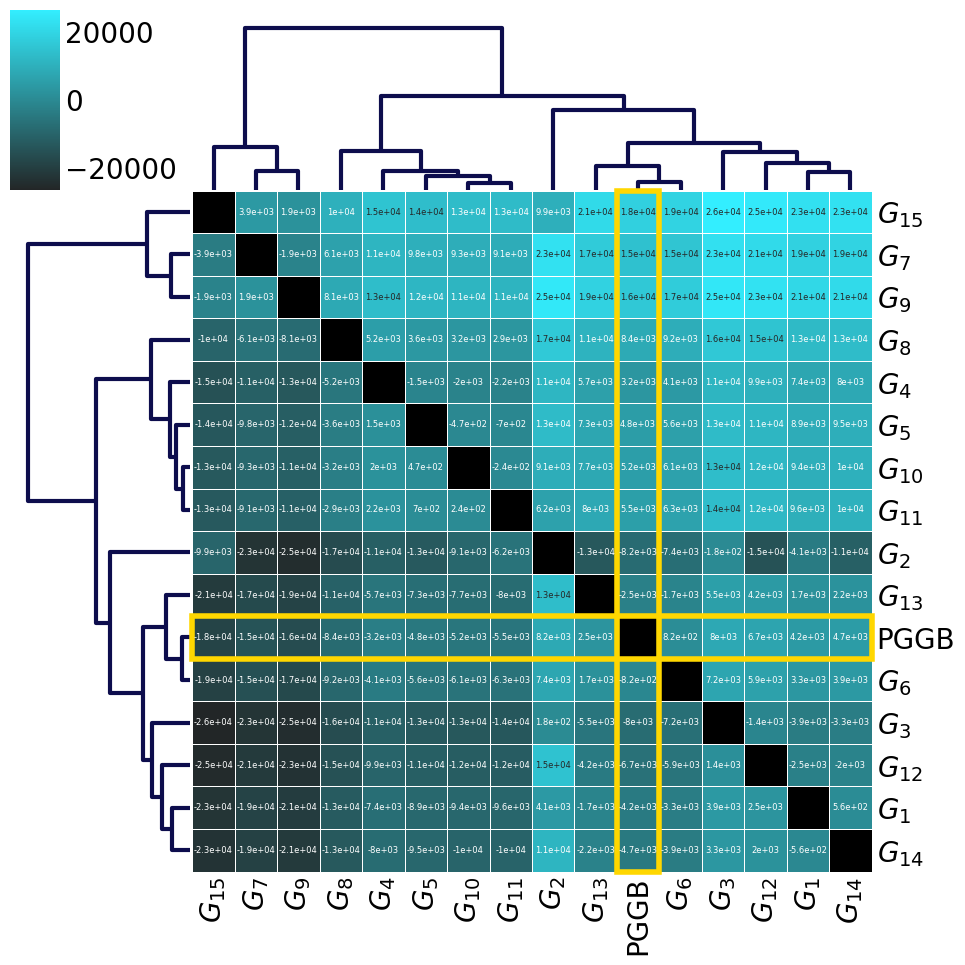

In [ ]:
# corr =  df.corr()
# Create a mask
# mask = triu(ones_like(corr, dtype=bool))
# Plotting the fig
fig = clustermap(
    df_deltas,
    linewidth=0.5,
    mask=(df==0),
    annot=True,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.05, 0.3)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    annot_kws={"size": 6},
    #col_colors=colors,
    #row_colors=colors,
)
#fig.figure.suptitle('$\Delta$ between splits and merges') 
#fig.figure.subplots_adjust(top=.9)
#xticklabels=['PGGB']+[round(mean_mash[x],3) for x in graph_paths],
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)

# We add a square to highlight a specific graph
reordered_labels:list[int] = df.index[fig.dendrogram_row.reordered_ind].tolist()
# PGGB is at location 0
pggb_pos:int = reordered_labels.index(0)
# We then add the patch to highlight the PGGB graph
x, y, w, h = 0, pggb_pos, len(reordered_labels), 1
for _ in range(2):
    fig.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='gold', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h

#plt.show()

In [ ]:
variants_file:str = "var"
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]
similarity_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

matrix:str = '../temp/variants_pggb_mgc.json'
sim_matrix:str = '../temp/similarity_pggb_mgc.json'


if path.exists(matrix) and path.exists(sim_matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
    similarity_martix: list[list[int]] = load(open(sim_matrix,'r',encoding='utf-8'))
else:
    for a, graph in enumerate(all_graphs):
        system(f'vg convert {graph_folder}/{graph_A} -W -f > ../temp/{graph_A}')
        if 'pggb' in graph:
            path_ref:list[str] = [x.split('_')[3] for x in all_graphs if 'pggb' not in x]
        else:
            path_ref:list[str] = [f'{graph.split("_")[3]}#{graph.split("_")[3]}']
            
        for pathr in path_ref:
            if not path.exists(f'../temp/{variants_file}_{path_ref}.vcf'):
                print(f'vg deconstruct -e -a -p "{pathr}" ../temp/{graph_A} > ../temp/{variants_file}_{pathr}.vcf')
                system(f'vg deconstruct -e -a -p "{pathr}" ../temp/{graph_A} > ../temp/{variants_file}_{pathr}.vcf')
                
    for i,graph_A in enumerate(all_graphs):
        if 'pggb' in graph_A:
            path_ref_A:list[str] = [x.split('_')[3] for x in all_graphs if 'pggb' not in x]
        else:
            path_ref_A:list[str] = [f'{graph_A.split("_")[3]}#{graph_A.split("_")[3]}']
        for j,graph_B in enumerate(all_graphs):
            if 'pggb' in graph_B:
                path_ref_B:list[str] = [x.split('_')[3] for x in all_graphs if 'pggb' not in x]
            else:
                path_ref_B:list[str] = [f'{graph_B.split("_")[3]}#{graph_B.split("_")[3]}']
            if i < j:
                common_variants:int = 0
                private_variants_A:int = 0
                private_variants_B:int = 0
                
                # Compute common and private variants
                for prA in path_ref_A:
                    for prB in path_ref_B:
                        
                        file_A_variants:dict[str,tuple] = dict()
                        with open(f'../temp/{variants_file}_{pathr}.vcf','r') as vcf_A:
                            for line in vcf_A:
                                if not line.startswith('#'):
                                    l:list[str] = line.split()
                                    file_A_variants[l[1]]=(l[3],l[4])
                                    
                        file_B_variants:dict[str,tuple] = dict()
                        with open(f'../temp/{variants_file}_{pathr}.vcf','r') as vcf_B:
                            for line in vcf_B:
                                if not line.startswith('#'):
                                    l:list[str] = line.split()
                                    file_B_variants[l[1]]=(l[3],l[4])
                                    
                        for pos in file_A_variants.keys():
                            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
                            if not is_common_variant:
                                private_variants_A += 1
                            else:
                                common_variants += 1

                        for pos in file_B_variants.keys():
                            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
                            if not is_common_variant:
                                private_variants_B += 1

                # add count to the two positions
                distance_martix[i][j] = (private_variants_A + private_variants_B) / (len(path_ref_A) * len(path_ref_B))
                distance_martix[j][i] = (private_variants_A + private_variants_B) / (len(path_ref_A) * len(path_ref_B))
                similarity_martix[i][j] = common_variants / (len(path_ref_A) * len(path_ref_B))
                # delete temp file
                #remove(edition_file)
                    
    dump(similarity_martix,open(sim_matrix,'w',encoding='utf-8'))
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))

In [ ]:
#system(f'rm ../temp/variants_pggb_mgc.json')
#system(f'rm ../temp/similarity_pggb_mgc.json')
#system(f'rm ../temp/var*')

In [ ]:
variants_file:str = "var"
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]
similarity_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

matrix:str = '../temp/variants_pggb_mgc.json'
sim_matrix:str = '../temp/similarity_pggb_mgc.json'

reference = 'CASBJU01'


if path.exists(matrix) and path.exists(sim_matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
    similarity_martix: list[list[int]] = load(open(sim_matrix,'r',encoding='utf-8'))
else:
    for a, graph in enumerate(all_graphs):
        system(f'vg convert {graph_folder}/{graph} -W -f > ../temp/{graph}')
        if 'pggb' in graph:
            pathr:str = reference
        elif reference in graph:
            pathr:str = f'{reference}#{reference}'
        else:
            pathr:str = f'{reference}#0#{reference}#0'
            
        if not path.exists(f'../temp/{variants_file}_{a}.vcf'):
            print(f'vg deconstruct -e -a -p "{pathr}" ../temp/{graph} > ../temp/{variants_file}_{a}.vcf')
            system(f'vg deconstruct -e -a -p "{pathr}" ../temp/{graph} > ../temp/{variants_file}_{a}.vcf')
                
    for i,graph_A in enumerate(all_graphs):

        for j,graph_B in enumerate(all_graphs):
            if 'pggb' in graph_B:
                path_ref_B:list[str] = [x.split('_')[3] for x in all_graphs if 'pggb' not in x]
            else:
                path_ref_B:list[str] = [f'{graph_B.split("_")[3]}#{graph_B.split("_")[3]}']
            if i < j:
                common_variants:int = 0
                private_variants_A:int = 0
                private_variants_B:int = 0
                
                # Compute common and private variants
                        
                file_A_variants:dict[str,tuple] = dict()
                with open(f'../temp/{variants_file}_{i}.vcf','r') as vcf_A:
                    for line in vcf_A:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            file_A_variants[l[1]]=(l[3],l[4])
                            
                file_B_variants:dict[str,tuple] = dict()
                with open(f'../temp/{variants_file}_{j}.vcf','r') as vcf_B:
                    for line in vcf_B:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            file_B_variants[l[1]]=(l[3],l[4])
                            
                for pos in file_A_variants.keys():
                    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
                    if not is_common_variant:
                        private_variants_A += 1
                    else:
                        common_variants += 1

                for pos in file_B_variants.keys():
                    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
                    if not is_common_variant:
                        private_variants_B += 1

                # add count to the two positions
                distance_martix[i][j] = (private_variants_A + private_variants_B) 
                distance_martix[j][i] = (private_variants_A + private_variants_B) 
                similarity_martix[i][j] = common_variants 
                # delete temp file
                #remove(edition_file)
                    
    dump(similarity_martix,open(sim_matrix,'w',encoding='utf-8'))
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))

4838.8125
[4218.9375, 4181.1875, 4215.8125, 3944.3125, 4201.8125, 4596.8125, 4476.5625, 3825.9375, 4034.3125, 3722.3125, 4093.1875, 4271.9375, 4452.8125, 4328.3125, 3821.0625]


/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


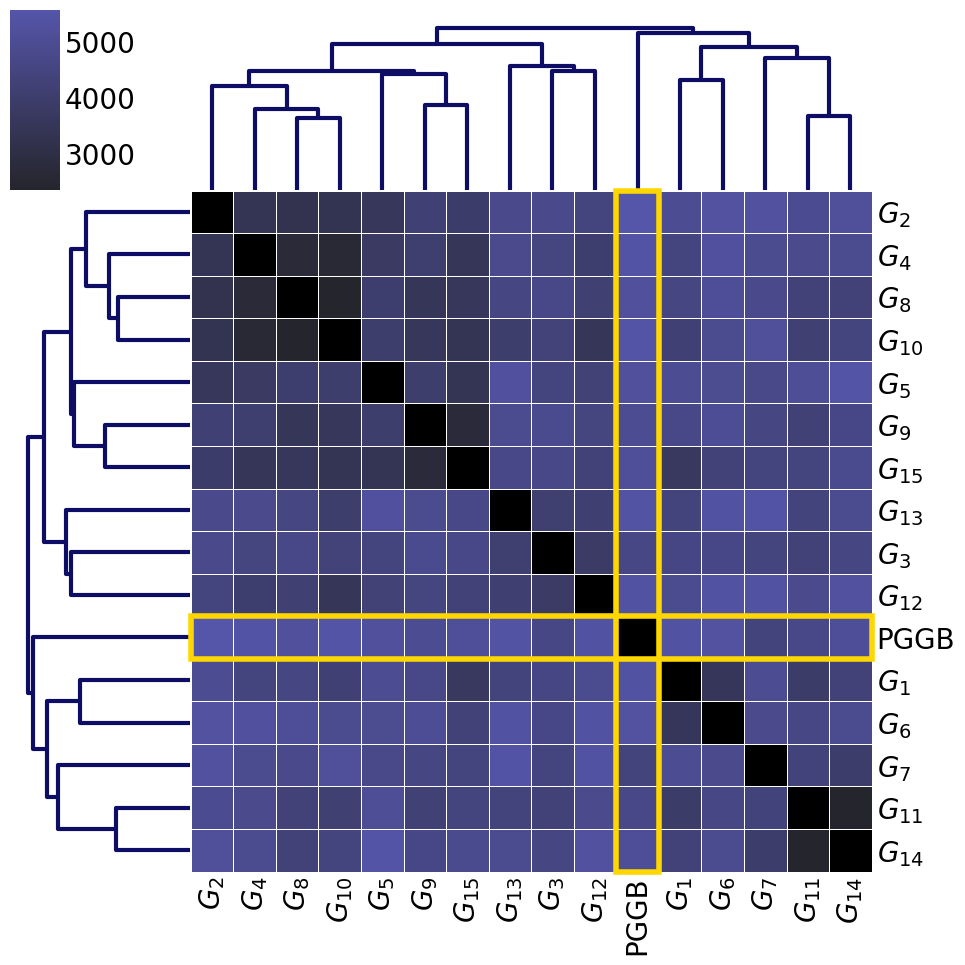

In [ ]:
# Setting font parameters
plt.rcParams.update({'font.size': 20})


print(mean(distance_martix[0]))
print([mean(x) for x in distance_martix[1:]])

# We define labels list
labels:list[str] = ['PGGB' if 'pggb' in label else '$G_{'+str(idx)+'}$' for idx,label in enumerate(all_graphs)]
# Defining colors
green_pal = color_palette("dark:#55A", as_cmap=True)
green_pal.set_bad("black")
colors = ['white'] + get_palette_from_list([sum_mash[x] for x in graph_paths],cmap_name='Greens')
# Transforming into pandas
df:DataFrame = DataFrame(distance_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.05, 0.4)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    #col_colors=colors,
    #row_colors=colors,
)
#xticklabels=['PGGB']+[round(mean_mash[x],3) for x in graph_paths],
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)

# We add a square to highlight a specific graph
reordered_labels:list[int] = df.index[fig.dendrogram_row.reordered_ind].tolist()
# PGGB is at location 0
pggb_pos:int = reordered_labels.index(0)
# We then add the patch to highlight the PGGB graph
x, y, w, h = 0, pggb_pos, len(reordered_labels), 1
for _ in range(2):
    fig.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='gold', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h

plt.savefig("SF3B.eps")
plt.show()

In [ ]:
sim_matrix:str = '../temp/similarity_pggb_mgc.json'

def flatten(xss):
    return [x for xs in xss for x in xs]

similarity: list[list[int]] = flatten(load(open(sim_matrix,'r',encoding='utf-8')))

#print(f"Total: r={round(stats.spearmanr(similarity,editions)[0],2)}, p={stats.spearmanr(similarity,editions)[1]:.2e}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Total: r=0.82, p=4.43e-64


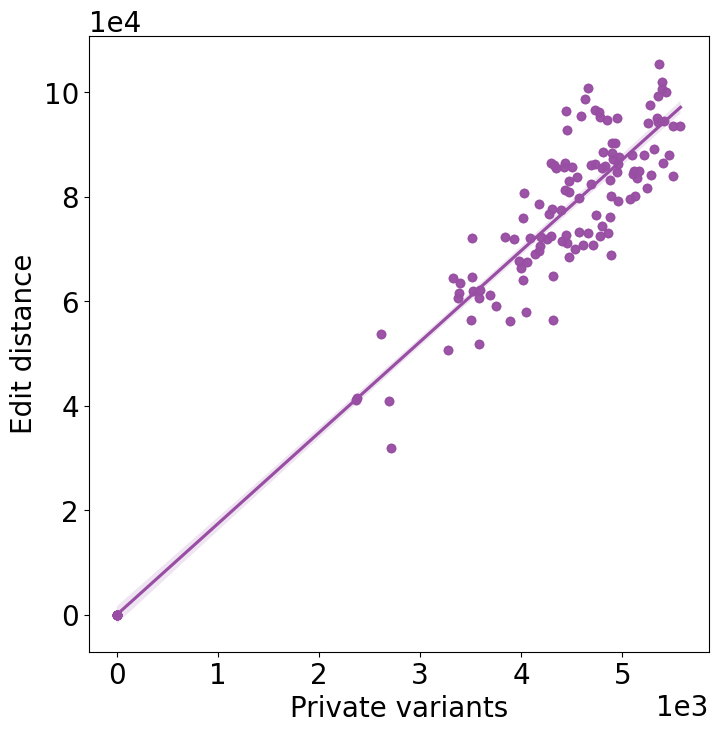

In [ ]:

from scipy import stats

matrix_variants:str = '../temp/variants_pggb_mgc.json'
matrix_editions:str = '../temp/matrix.json'

def flatten(xss):
    return [x for xs in xss for x in xs]

variants: list[list[int]] = flatten(load(open(matrix_variants,'r',encoding='utf-8')))
editions: list[list[int]] = flatten(load(open(matrix_editions,'r',encoding='utf-8')))

cb_colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

print(f"Total: r={round(stats.spearmanr(variants,editions)[0],2)}, p={stats.spearmanr(variants,editions)[1]:.2e}")

plt.figure(figsize=(8,8))
regplot(
    x=variants,
    y=editions,
    scatter=True,
    color=cb_colors['purple'],
)
#scatterplot(x=variants,y=editions,alpha=0.5,color=cb_colors['blue'])
plt.ticklabel_format(style='sci', axis='x', scilimits=(3,4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(4,4))
plt.xlabel('Private variants')
plt.ylabel('Edit distance')
#plt.title(f"r={round(stats.pearsonr(variants,editions)[0],2)}, p={stats.pearsonr(variants,editions)[1]:.2e}")
#plt.title(f"r={round(stats.spearmanr(variants,editions)[0],2)}, p={stats.spearmanr(variants,editions)[1]:.2e}")
plt.savefig("SF3C.eps")
plt.show()

In [ ]:
for i in range(len(distance_martix)):
    for j in range(len(distance_martix)):
        distance_martix[i][j] = -1 if distance_martix[i][j] < 0 else 1

df_deltas:DataFrame = DataFrame(distance_martix)

In [ ]:
matrix:str = '../temp/matrix_ref.json'
graph_folder:str = '../data/mgc_vs_mgc'

In [ ]:
all_graphs: list = sorted(listdir(graph_folder))
print(all_graphs)

['15_yeast_rotate_CASBJG01_1.gfa', '15_yeast_rotate_CASBJG01_2.gfa', '15_yeast_rotate_CASBJG01_3.gfa', '15_yeast_rotate_CASBJT01_1.gfa', '15_yeast_rotate_CASBJT01_2.gfa', '15_yeast_rotate_CASBJT01_3.gfa', '15_yeast_rotate_CASBJU01_1.gfa', '15_yeast_rotate_CASBJU01_2.gfa', '15_yeast_rotate_CASBJU01_3.gfa']


In [ ]:
# First, we compute edition to be sure to have a list of breakpoints
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

if path.exists(matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
else:
    for i,graph_A in enumerate(all_graphs):
        for j,graph_B in enumerate(all_graphs):
            if i < j:
                # Compute edition
                system(f'pancat edit ../data/{graph_A} ../data/{graph_B} -o {edition_file}_{i}_{j}.json')
                # Load edit file in memory
                editions:dict[str,list] = load(open(f"{edition_file}_{i}_{j}.json",'r',encoding='utf-8'))
                # Count editions
                edit_count:int = sum([sum([len(edit_list) for edit_list in edition_classes.values()]) for edition_classes in editions.values()])
                # add count to the two positions
                distance_martix[i][j] = edit_count
                distance_martix[j][i] = edit_count
                # delete temp file
                #remove(edition_file)
                
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))

In [ ]:
for row in distance_martix:
    print("\t".join([str(elt) for elt in row]))

0	10795	8528	81980	74195	78102	62844	69933	63904
10795	0	4541	74569	81054	84639	70723	66174	72239
8528	4541	0	75110	80269	82998	69800	64081	70996
81980	74569	75110	0	15787	13318	79794	75621	82000
74195	81054	80269	15787	0	12203	72779	80080	74833
78102	84639	82998	13318	12203	0	76898	82809	78280
62844	70723	69800	79794	72779	76898	0	11623	5582
69933	66174	64081	75621	80080	82809	11623	0	7759
63904	72239	70996	82000	74833	78280	5582	7759	0


['#377eb8', '#377eb8', '#377eb8', '#984ea3', '#984ea3', '#984ea3', '#dede00', '#dede00', '#dede00']


/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


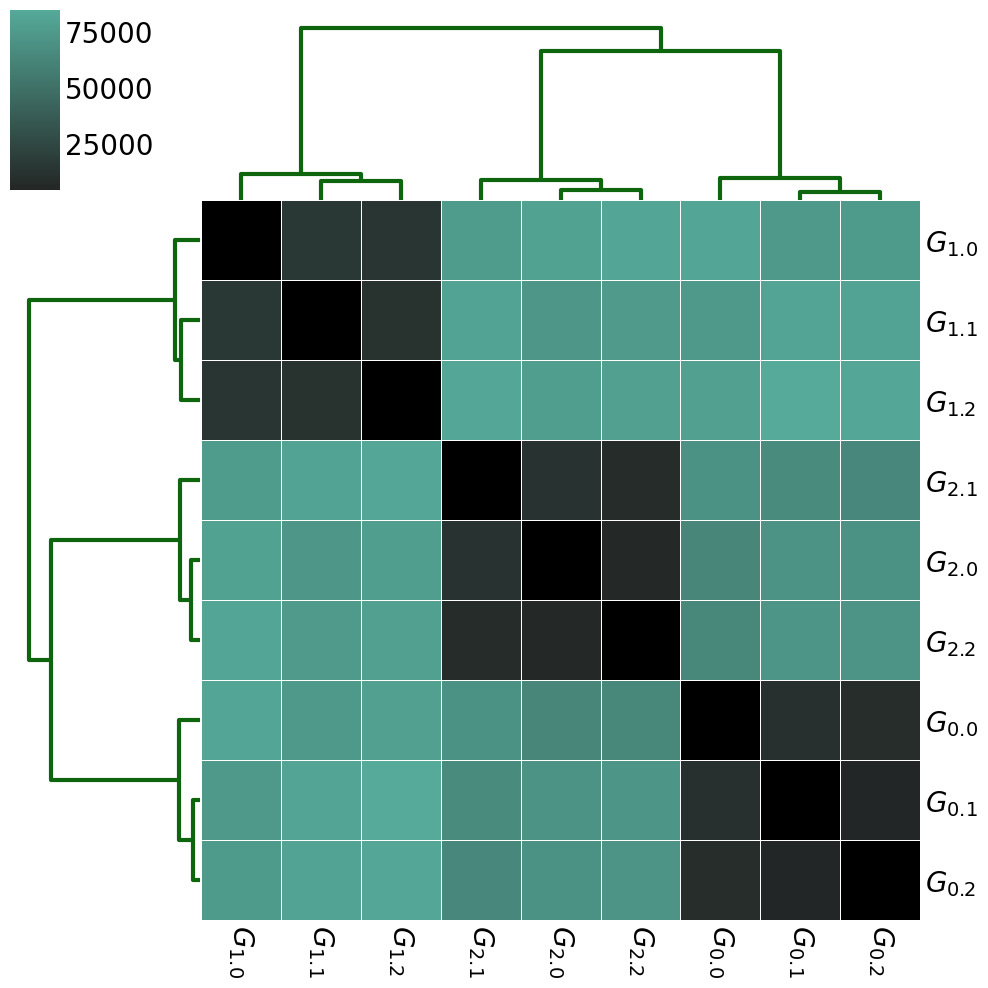

In [ ]:
opacity:float = 1.0
cb_colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 


# Setting font parameters
plt.rcParams.update({'font.size': 20})

# We define labels list
labels:list[str] = ['$G_{'+str(i//3)+'.'+str(i%3)+'}$' for i in range(len(all_graphs))]
# Defining colors
green_pal = color_palette("dark:#5A9", as_cmap=True)
green_pal.set_bad("black")
colors:list[str] = [cb_colors['blue'] for _ in range(3)] + [cb_colors['purple'] for _ in range(3)] + [cb_colors['yellow'] for _ in range(3)]
print(colors)
# Transforming into pandas
df:DataFrame = DataFrame(distance_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.4, 0.05)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    #col_colors=colors,
    #row_colors=colors,
)
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_yticklabels(), rotation=-90)
plt.savefig("F1A.eps")
plt.show()

We will now check if the same profile can be achieved with private variants

In [ ]:
variants_file_A:str = "growth_mgc"
variants_file_B:str = "growth_pggb"
distance_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]
similarity_martix:list[list[int]] = [[0 for _ in all_graphs] for _ in all_graphs]

matrix:str = '../temp/variants_rotate_ref.json'
sim_matrix:str = '../temp/similarity_rotate_ref.json'

references = ['seq2#CASBJG01','seq14#CASBJT01','seq0#CASBJU01']

if path.exists(matrix) and path.exists(sim_matrix):
    distance_martix: list[list[int]] = load(open(matrix,'r',encoding='utf-8'))
    similarity_martix: list[list[int]] = load(open(sim_matrix,'r',encoding='utf-8'))
else:
    for i,graph_A in enumerate(all_graphs):
        system(f'vg convert {graph_folder}/{graph_A} -W -f > ../temp/{graph_A}')
        for j,graph_B in enumerate(all_graphs):
            if i < j:
                path_ref_A:str = f'{references[int(i/3)]}'
                path_ref_B:str = f'{references[int(j/3)]}'
                
                common_variants:int = 0
                private_variants_A:int = 0
                private_variants_B:int = 0
                # Compute variants
                if not path.exists(f'../temp/{variants_file_A}_{i}_{j}.vcf'):
                    system(f'vg deconstruct -e -a -p "{path_ref_A}" ../temp/{graph_A} > ../temp/{variants_file_A}_{i}_{j}.vcf') # format for raw cactus files > "seq000#{reference[0]}"
                if not path.exists(f'../temp/{variants_file_B}_{i}_{j}.vcf'):
                    system(f'vg deconstruct -e -a -p "{path_ref_B}" ../temp/{graph_B} > ../temp/{variants_file_B}_{i}_{j}.vcf') # format for raw pggb files > "seq000"
                
                # Compute common and private variants
                file_A_variants:dict[str,tuple] = dict()
                with open(f'../temp/{variants_file_A}_{i}_{j}.vcf','r') as vcf_A:
                    for line in vcf_A:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            file_A_variants[l[1]]=(l[3],l[4])
                            
                file_B_variants:dict[str,tuple] = dict()
                with open(f'../temp/{variants_file_B}_{i}_{j}.vcf','r') as vcf_B:
                    for line in vcf_B:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            file_B_variants[l[1]]=(l[3],l[4])
                            
                for pos in file_A_variants.keys():
                    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
                    if not is_common_variant:
                        private_variants_A += 1
                    else:
                        common_variants += 1

                for pos in file_B_variants.keys():
                    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
                    if not is_common_variant:
                        private_variants_B += 1

                # add count to the two positions
                distance_martix[i][j] = private_variants_A + private_variants_B
                distance_martix[j][i] = private_variants_A + private_variants_B
                similarity_martix[i][j] = common_variants
                # delete temp file
                #remove(edition_file)
                    
    dump(similarity_martix,open(sim_matrix,'w',encoding='utf-8'))
    dump(distance_martix,open(matrix,'w',encoding='utf-8'))


['#377eb8', '#377eb8', '#377eb8', '#984ea3', '#984ea3', '#984ea3', '#dede00', '#dede00', '#dede00']


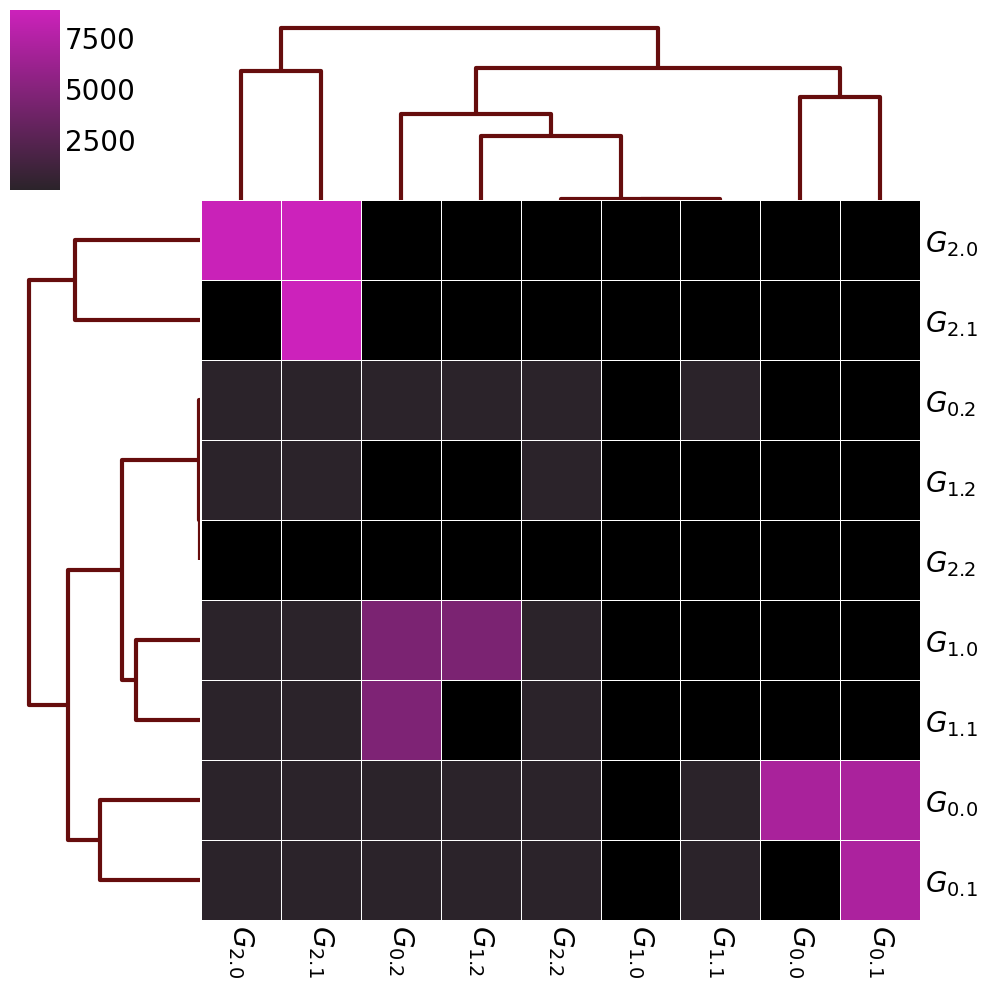

In [ ]:
opacity:float = 1.0
cb_colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 


# Setting font parameters
plt.rcParams.update({'font.size': 20})

# We define labels list
labels:list[str] = ['$G_{'+str(i//3)+'.'+str(i%3)+'}$' for i in range(len(all_graphs))]
# Defining colors
green_pal = color_palette("dark:#C2B", as_cmap=True)
green_pal.set_bad("black")
colors:list[str] = [cb_colors['blue'] for _ in range(3)] + [cb_colors['purple'] for _ in range(3)] + [cb_colors['yellow'] for _ in range(3)]
print(colors)
# Transforming into pandas
df:DataFrame = DataFrame(similarity_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.4, 0.05, 0.05)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    #col_colors=colors,
    #row_colors=colors,
)
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_yticklabels(), rotation=-90)

plt.show()

['#377eb8', '#377eb8', '#377eb8', '#984ea3', '#984ea3', '#984ea3', '#dede00', '#dede00', '#dede00']


/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/sidubois/miniconda3/envs/dev/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


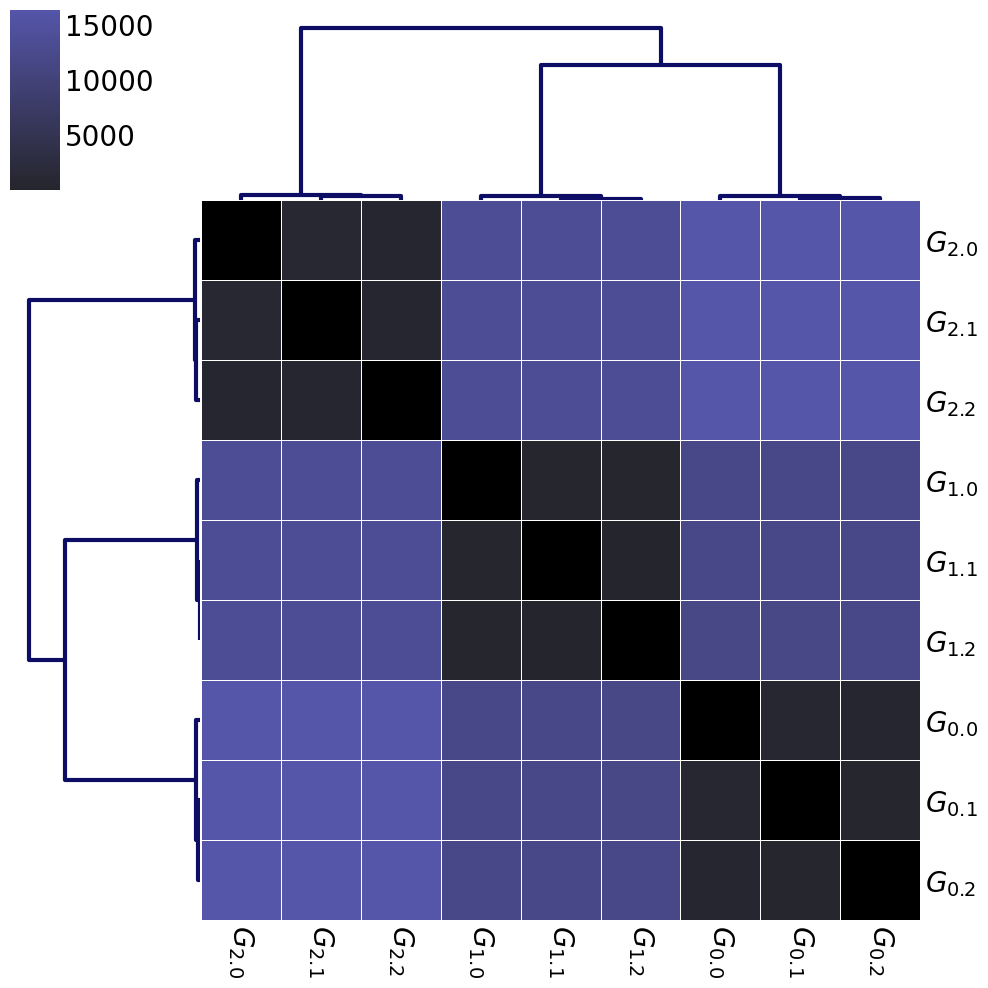

In [ ]:
opacity:float = 1.0
cb_colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 


# Setting font parameters
plt.rcParams.update({'font.size': 20})

# We define labels list
labels:list[str] = ['$G_{'+str(i//3)+'.'+str(i%3)+'}$' for i in range(len(all_graphs))]
# Defining colors
green_pal = color_palette("dark:#55A", as_cmap=True)
green_pal.set_bad("black")
colors:list[str] = [cb_colors['blue'] for _ in range(3)] + [cb_colors['purple'] for _ in range(3)] + [cb_colors['yellow'] for _ in range(3)]
print(colors)
# Transforming into pandas
df:DataFrame = DataFrame(distance_martix)
# Plotting the fig
fig = clustermap(
    df,
    linewidth=0.5,
    mask=(df==0),
    annot=False,
    tree_kws=dict(linewidths=3, colors=(0.05, 0.05, 0.4)),
    xticklabels=labels,
    yticklabels=labels,
    cmap=green_pal,
    #col_colors=colors,
    #row_colors=colors,
)
fig.tick_params(length=0)
fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_yticklabels(), rotation=0)
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_yticklabels(), rotation=-90)
plt.savefig("SF3A.eps")
plt.show()

<Axes: >

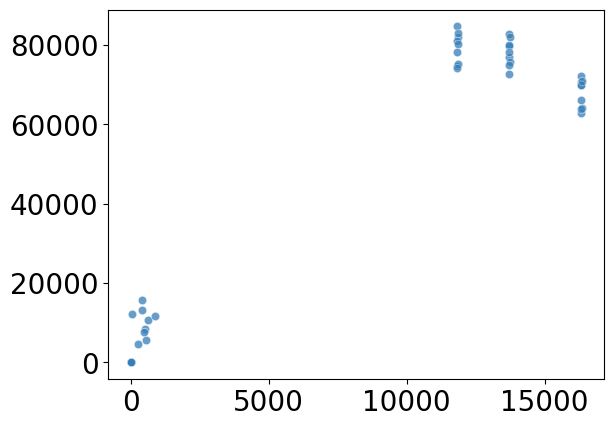

In [ ]:
matrix_variants:str = '../temp/variants_rotate_ref.json'
matrix_editions:str = '../temp/matrix_ref.json'

def flatten(xss):
    return [x for xs in xss for x in xs]

variants: list[list[int]] = flatten(load(open(matrix_variants,'r',encoding='utf-8')))
editions: list[list[int]] = flatten(load(open(matrix_editions,'r',encoding='utf-8')))



scatterplot(
    x=variants,
    y=editions,
    alpha=0.5,
    color=cb_colors['blue']
)